In [2]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load Table

In [3]:
# pickle에서 데이터프레임 다시 불러오기
with open('data.pickle', 'rb') as f:
    df = pickle.load(f)

In [4]:
df

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,동,계약년,계약월,평균공시가격,계약일,date
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,개포동,2017,12,120960.000000,8,2017-12-08
1,658-1,658.0,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,개포동,2017,12,120960.000000,22,2017-12-22
2,658-1,658.0,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,개포동,2017,12,120960.000000,28,2017-12-28
3,658-1,658.0,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,개포동,2018,01,120960.000000,3,2018-01-03
4,658-1,658.0,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,개포동,2018,01,120960.000000,8,2018-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,816.0,신내우디안1단지,84.65,202307,13,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,07,39021.326676,19,2023-07-19
1128090,816,816.0,신내우디안1단지,84.62,202307,12,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,07,39021.326676,25,2023-07-25
1128091,816,816.0,신내우디안1단지,101.65,202308,12,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,08,39021.326676,27,2023-08-27
1128092,816,816.0,신내우디안1단지,84.94,202309,18,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,09,39021.326676,2,2023-09-02


In [5]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt_train = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1
dt = pd.concat([dt_train, dt_test])

In [6]:
df['large_std_동'] = df['동']
df.drop(['동'], axis=1, inplace=True)

In [7]:
dt['동'] = dt['시군구'].apply(lambda x:x.split()[2])

In [8]:
dt = dt.reset_index()

In [9]:
df['동'] = dt['동']

In [10]:
df.head()

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,계약일,date,large_std_동,동
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.0,8,2017-12-08,개포동,개포동
1,658-1,658.0,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,2017,12,120960.0,22,2017-12-22,개포동,개포동
2,658-1,658.0,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,2017,12,120960.0,28,2017-12-28,개포동,개포동
3,658-1,658.0,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,2018,01,120960.0,3,2018-01-03,개포동,개포동
4,658-1,658.0,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,2018,01,120960.0,8,2018-01-08,개포동,개포동


### 년도에따라 동, 구별 statistics 추가

In [11]:
df.drop(['아파트명', '계약일'], axis=1, inplace=True)

In [12]:
df.head(1)

,번지,본번,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,date,large_std_동,동
0,658-1,658.0,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.0,2017-12-08,개포동,개포동


In [13]:
stats = df.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '구'], rsuffix='_target')

In [14]:
df['계약년과구에따른std'] = df['std']
df['계약년과구에따른mean'] = df['mean']
df['계약년과구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max
0,658-1,658.0,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.0,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0


In [15]:
stats = df.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '동'], rsuffix='_target')

In [16]:
df['계약년과동에따른std'] = df['std']
df['계약년과동에따른mean'] = df['mean']
df['계약년과동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,...,평균공시가격,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max
0,658-1,658.0,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,...,120960.0,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0,32126.755612,108070.249556,260000.0


In [17]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['계약년과동에따른std'] = df['계약년과동에따른std'].fillna(df['계약년과구에따른std'])
df['계약년과동에따른mean'] = df['계약년과동에따른mean'].fillna(df['계약년과구에따른mean'])
df['계약년과동에따른max'] = df['계약년과동에따른max'].fillna(df['계약년과구에따른max'])

In [18]:
df.drop(['동', 'large_std_동', '계약월', 'date', '본번', '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max', '계약년'], axis=1, inplace=True)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1128094 entries, 0 to 1128093
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   번지            1128094 non-null  object 
 1   전용면적(㎡)       1128094 non-null  float64
 2   계약년월          1128094 non-null  int64  
 3   층             1128094 non-null  int64  
 4   건축년도          1128094 non-null  int64  
 5   도로명           1128094 non-null  object 
 6   target        1118822 non-null  float64
 7   is_test       1128094 non-null  int64  
 8   구             1128094 non-null  object 
 9   평균공시가격        1128094 non-null  float64
 10  계약년과동에따른std   1128094 non-null  float64
 11  계약년과동에따른mean  1128094 non-null  float64
 12  계약년과동에따른max   1128094 non-null  float64
dtypes: float64(6), int64(4), object(3)
memory usage: 120.5+ MB


### Feature Engineering

### Train

In [20]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 12) (9272, 12)


In [21]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약년월', '층', '건축년도', 'target', '평균공시가격', '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max']
범주형 변수: ['번지', '도로명', '구']


In [23]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

  0%|          | 0/3 [00:00<?, ?it/s]


ValueError: y contains previously unseen labels: '6573'

In [22]:
y_train = df_train['target']
X_train = df_train.drop(['target'], axis=1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

### Model Train - XGBoost

In [45]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=2000, max_depth=32, max_leaves=60,
                             colsample_bytree=0.8, subsample=0.9, verbosity=0)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              eval_metric='rmse',
              early_stopping_rounds=50,
              verbose=100)

[0]	validation_0-rmse:35021.01833	validation_1-rmse:35362.37264
[100]	validation_0-rmse:7412.18548	validation_1-rmse:7980.48192
[200]	validation_0-rmse:6461.68292	validation_1-rmse:7251.89383
[300]	validation_0-rmse:5911.51583	validation_1-rmse:6916.40681
[400]	validation_0-rmse:5558.32492	validation_1-rmse:6735.71479
[500]	validation_0-rmse:5298.21808	validation_1-rmse:6606.33837
[600]	validation_0-rmse:5091.90548	validation_1-rmse:6522.67807
[700]	validation_0-rmse:4924.16300	validation_1-rmse:6472.25689
[800]	validation_0-rmse:4785.32573	validation_1-rmse:6429.61291
[900]	validation_0-rmse:4668.19663	validation_1-rmse:6399.82631
[1000]	validation_0-rmse:4565.05416	validation_1-rmse:6372.05624
[1100]	validation_0-rmse:4469.96318	validation_1-rmse:6352.51727
[1200]	validation_0-rmse:4389.93835	validation_1-rmse:6337.89625
[1300]	validation_0-rmse:4317.34346	validation_1-rmse:6327.59752
[1400]	validation_0-rmse:4251.75944	validation_1-rmse:6307.46725
[1500]	validation_0-rmse:4187.10048

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=32, max_leaves=60,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
X_test = df_test.drop(['target'], axis=1)
real_test_pred = xgb_model.predict(X_test)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('계약년과동에따른xgb.csv', index=False)

In [47]:
preds_df.describe()

,target
count,9.272000e+03
mean,1.078110e+05
std,7.760352e+04
min,5.909000e+03
25%,6.307675e+04
50%,8.804450e+04
75%,1.275018e+05
max,1.336704e+06


### Model Train - CatBoost

In [36]:
from catboost import CatBoostRegressor

# CatBoostRegressor 객체 생성 및 하이퍼파라미터 설정
cat_model = CatBoostRegressor(
    n_estimators=2000,       # 트리 개수를 늘림
    max_depth=10,            # 적절한 깊이로 설정
    task_type='GPU'          # GPU 사용
)

# 모델 학습
cat_model.fit(
    X_train, y_train,        # 학습 데이터
    eval_set=(X_val, y_val), # 평가 데이터
    metric_period=200,       # 200번째 반복마다 평가 지표 출력
    early_stopping_rounds=100,# 100번 반복 동안 성능 향상 없으면 조기 종료
    use_best_model=True      # 가장 좋은 성능의 모델 사용
)

Learning rate set to 0.106198
0:	learn: 42236.1466460	test: 42571.8069740	best: 42571.8069740 (0)	total: 12.5ms	remaining: 25s
200:	learn: 7588.5147298	test: 8120.2551799	best: 8120.2551799 (200)	total: 1.48s	remaining: 13.2s
400:	learn: 6681.0687851	test: 7380.4394260	best: 7380.4394260 (400)	total: 2.94s	remaining: 11.7s
600:	learn: 6211.7212998	test: 7068.0204606	best: 7068.0204606 (600)	total: 4.4s	remaining: 10.3s
800:	learn: 5883.6824150	test: 6897.4153174	best: 6896.8639676 (799)	total: 5.88s	remaining: 8.8s
1000:	learn: 5642.9662530	test: 6786.1614654	best: 6786.1614654 (1000)	total: 7.34s	remaining: 7.32s
1200:	learn: 5458.5923567	test: 6700.1695630	best: 6700.0730459 (1197)	total: 8.81s	remaining: 5.86s
1400:	learn: 5307.5293083	test: 6636.5563305	best: 6636.4705391 (1398)	total: 10.3s	remaining: 4.39s
1600:	learn: 5189.8409762	test: 6594.9184483	best: 6594.9184483 (1600)	total: 11.7s	remaining: 2.92s
1800:	learn: 5076.3786349	test: 6553.7546604	best: 6552.8297181 (1793)	tota

In [39]:
X_test = df_test.drop(['target'], axis=1)
real_test_pred = cat_model.predict(X_test)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('계약년과동에따른.csv', index=False)

In [40]:
preds_df.describe()

,target
count,9.272000e+03
mean,1.070703e+05
std,7.676328e+04
min,7.885000e+03
25%,6.286500e+04
50%,8.754050e+04
75%,1.263052e+05
max,1.095998e+06


### Model Train - lgb

In [24]:
# import optuna

# def objective(trial):
#     # Define the hyperparameter search space
#     n_estimators = trial.suggest_int('n_estimators', 1000, 5000)
#     max_depth = trial.suggest_int('max_depth', 10, 50)
#     num_leaves = trial.suggest_int('num_leaves', 100, 1000)
#     min_child_samples = trial.suggest_int('min_child_samples', 50, 500)
#     feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
#     bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
#     lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True)  # Increase L1 regularization
#     lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True)  # Increase L2 regularization

#     # Create the LGBMRegressor model with the suggested hyperparameters
#     gbm = lgb.LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves,
#                             min_child_samples=min_child_samples, feature_fraction=feature_fraction,
#                             bagging_fraction=bagging_fraction, lambda_l1=lambda_l1, lambda_l2=lambda_l2, verbosity=-1)

#     # Train the model
#     gbm.fit(
#         X_train, y_train, 
#         eval_set=[(X_train, y_train), (X_val, y_val)], 
#         eval_metric='rmse',
#         callbacks=[lgb.early_stopping(stopping_rounds=50),
#                    lgb.log_evaluation(period=100, show_stdv=True)]
#         )
    
#     # Compute the validation RMSE
#     val_rmse = gbm.best_score_['valid_1']['rmse']
#     return val_rmse

# def optimize_hyperparameters(n_trials=100, early_stopping=50, log_evaluation=100):
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=n_trials)

#     # Get the best hyperparameters
#     best_params = study.best_trial.params

#     # Create the final model with the best hyperparameters
#     best_model = lgb.LGBMRegressor(**best_params)

#     # Train the final model with early stopping and evaluation logging
#     best_model.fit(X_train, y_train,
#                    eval_set=[(X_train, y_train), (X_val, y_val)],
#                    eval_metric='rmse',
#                    callbacks=[lgb.early_stopping(stopping_rounds=early_stopping),
#                               lgb.log_evaluation(period=log_evaluation, show_stdv=True)])

#     return best_model

In [ ]:
# best_model = optimize_hyperparameters(n_trials=100)

In [48]:
gbm = lgb.LGBMRegressor(n_estimators=2000, max_depth=32, num_leaves=60,
                            feature_fraction=0.8,
                            bagging_fraction=0.9, verbosity=-1)

gbm.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7868.93	training's l2: 6.192e+07	valid_1's rmse: 8225.76	valid_1's l2: 6.76632e+07
[200]	training's rmse: 6889.16	training's l2: 4.74605e+07	valid_1's rmse: 7340.98	valid_1's l2: 5.389e+07
[300]	training's rmse: 6373.22	training's l2: 4.06179e+07	valid_1's rmse: 6924.4	valid_1's l2: 4.79473e+07
[400]	training's rmse: 6025.19	training's l2: 3.63029e+07	valid_1's rmse: 6666.95	valid_1's l2: 4.44483e+07
[500]	training's rmse: 5763.61	training's l2: 3.32192e+07	valid_1's rmse: 6482.81	valid_1's l2: 4.20269e+07
[600]	training's rmse: 5552.7	training's l2: 3.08325e+07	valid_1's rmse: 6343.29	valid_1's l2: 4.02374e+07
[700]	training's rmse: 5386.09	training's l2: 2.90099e+07	valid_1's rmse: 6240.17	valid_1's l2: 3.89397e+07
[800]	training's rmse: 5242.09	training's l2: 2.74795e+07	valid_1's rmse: 6150.28	valid_1's l2: 3.7826e+07
[900]	training's rmse: 5120.26	training's l2: 2.62171e+07	valid_1's rmse: 6078.94	

LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.8, max_depth=32,
              n_estimators=2000, num_leaves=60, verbosity=-1)

In [49]:
X_test = df_test.drop(['target'], axis=1)
real_test_pred = gbm.predict(X_test)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('계약년과동에따른lgb.csv', index=False)

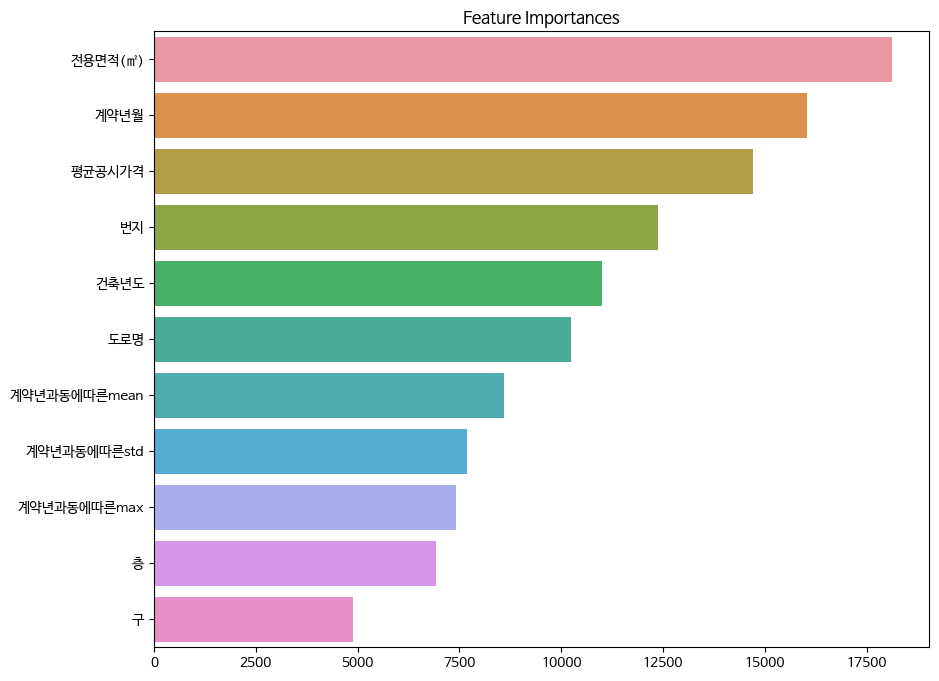

In [50]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [51]:
preds_df.describe()

,target
count,9.272000e+03
mean,1.079267e+05
std,7.805347e+04
min,6.572000e+03
25%,6.357775e+04
50%,8.801000e+04
75%,1.279822e+05
max,1.287191e+06
